In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset
import torchvision
from torchvision import transforms

from dataloading.nvidia import NvidiaCropWide, Normalize, NvidiaDataset
from network import PilotNet
from trainer import Trainer

import wandb

%load_ext autoreload
%autoreload 2

## Datasets

In [2]:
root_path = Path("/home/romet/projects/ut/wp4/dataset")
paths = [
#     root_path / "2021-05-20-12-36-10_e2e_sulaoja_20_30",
#     root_path / "2021-05-20-12-43-17_e2e_sulaoja_20_30", 
#     root_path / "2021-05-20-12-51-29_e2e_sulaoja_20_30",
#     root_path / "2021-05-20-13-44-06_e2e_sulaoja_10_10",
#     root_path / "2021-05-20-13-51-21_e2e_sulaoja_10_10",
#     root_path / "2021-05-20-13-59-00_e2e_sulaoja_10_10",
#     root_path / "2021-05-28-15-07-56_e2e_sulaoja_20_30",
#     root_path / "2021-05-28-15-17-19_e2e_sulaoja_20_30",               
#     root_path / "2021-06-07-14-06-31_e2e_rec_ss6",
#     root_path / "2021-06-07-14-09-18_e2e_rec_ss6",
#     root_path / "2021-06-07-14-36-16_e2e_rec_ss6",
#     root_path / "2021-06-09-13-14-51_e2e_rec_ss2",
#     root_path / "2021-06-09-13-55-03_e2e_rec_ss2_backwards",
#     root_path / "2021-06-09-14-58-11_e2e_rec_ss3",
#     root_path / "2021-06-09-15-42-05_e2e_rec_ss3_backwards",
#     root_path / "2021-06-09-16-24-59_e2e_rec_ss13",
#     root_path / "2021-06-09-16-50-22_e2e_rec_ss13_backwards",
#     root_path / "2021-06-10-12-59-59_e2e_ss4",
#     root_path / "2021-06-10-13-19-22_e2e_ss4_backwards",
#     root_path / "2021-06-10-13-51-34_e2e_ss12",
#     root_path / "2021-06-10-14-02-24_e2e_ss12_backwards",
#     root_path / "2021-06-10-14-44-24_e2e_ss3_backwards",
#     root_path / "2021-06-10-15-03-16_e2e_ss3_backwards",
#     root_path / "2021-06-14-11-08-19_e2e_rec_ss14",
#     root_path / "2021-06-14-11-43-48_e2e_rec_ss14_backwards",
#     root_path / "2021-05-28-15-19-48_e2e_sulaoja_20_30",
#     root_path / "2021-06-07-14-20-07_e2e_rec_ss6",
#     root_path / "2021-06-14-11-22-05_e2e_rec_ss14",
    root_path / "2021-10-11-14-50-59_e2e_rec_vahi",
    #root_path / "2021-10-11-15-06-10_e2e_rec_vahi_backwards"
]


dataset = NvidiaDataset(paths, camera="front_wide", transform=None)
positions_df = dataset.frames[:15400]

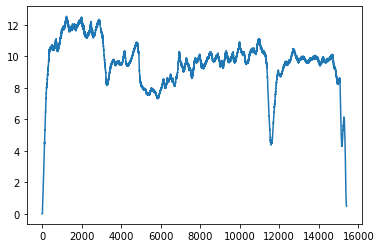

In [3]:
plt.plot(positions_df.vehicle_speed)

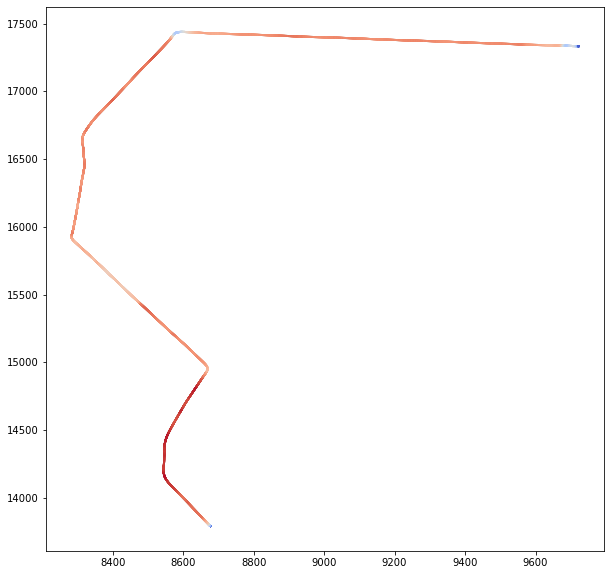

In [4]:
plt.figure(figsize=(10, 10))
plt.scatter(positions_df["position_x"], positions_df["position_y"],
            s=1,
            c=positions_df["vehicle_speed"], cmap=plt.cm.coolwarm);

In [5]:
velocity = 30
positions_df["position_x2"] = positions_df["position_x"] + (velocity * np.cos(positions_df["yaw"]))
positions_df["position_y2"] = positions_df["position_y"] + (velocity * np.sin(positions_df["yaw"]))
positions_df = positions_df[["position_x", "position_y", "position_x2", "position_y2", "yaw", "vehicle_speed", "image_path", "autonomous"]]

/tmp/ipykernel_2204013/2942998590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_df["position_x2"] = positions_df["position_x"] + (velocity * np.cos(positions_df["yaw"]))
/tmp/ipykernel_2204013/2942998590.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_df["position_y2"] = positions_df["position_y"] + (velocity * np.sin(positions_df["yaw"]))


In [6]:
positions_df[["position_x", "position_y", "yaw"]]

,position_x,position_y,yaw
2,8677.194417,13790.814799,1.928472
3,8677.193896,13790.816099,1.928461
4,8677.193225,13790.817806,1.928442
5,8677.192413,13790.819966,1.928413
6,8677.191353,13790.822878,1.928418
...,...,...,...
15397,9722.529379,17332.792044,-0.091049
15398,9722.546128,17332.791201,-0.091357
15399,9722.563560,17332.790133,-0.091655
15400,9722.580380,17332.788932,-0.091861


In [7]:
positions_df.to_parquet('positions.parquet', compression='GZIP')

In [21]:
from velocity_model.velocity_model import VelocityModel

velocity_model = VelocityModel(positions_parquet='velocity_model/positions.parquet')
#positions_df = pd.read_parquet('positions.parquet')
#tree = BallTree(positions_df[["position_x", "position_y", "position_x2", "position_y2"]]) 
#tree = BallTree(positions_df[["position_x", "position_y", "yaw"]]) 

In [24]:
velocity_model.positions_df[5000:5100]

,position_x,position_y,position_x2,position_y2,yaw,vehicle_speed,image_path,autonomous
index,,,,,,,,
5002,8464.171708,15466.432695,8452.506618,15494.071901,1.970165,8.160716,/home/romet/projects/ut/wp4/dataset/2021-10-11...,False
5003,8464.068187,15466.676321,8452.402055,15494.315087,1.970202,8.189958,/home/romet/projects/ut/wp4/dataset/2021-10-11...,False
5004,8463.956017,15466.940217,8452.290871,15494.579399,1.970167,8.160213,/home/romet/projects/ut/wp4/dataset/2021-10-11...,False
5005,8463.847732,15467.194324,8452.184093,15494.834142,1.970112,8.100184,/home/romet/projects/ut/wp4/dataset/2021-10-11...,False
5006,8463.743389,15467.439201,8452.087183,15495.082154,1.969843,8.199381,/home/romet/projects/ut/wp4/dataset/2021-10-11...,False
...,...,...,...,...,...,...,...,...
5097,8454.180493,15490.326491,8442.920353,15518.133131,1.955558,8.030000,/home/romet/projects/ut/wp4/dataset/2021-10-11...,False
5098,8454.078585,15490.575209,8442.826189,15518.384984,1.955279,7.941316,/home/romet/projects/ut/wp4/dataset/2021-10-11...,False
5099,8453.980550,15490.814702,8442.733927,15518.626812,1.955072,7.996091,/home/romet/projects/ut/wp4/dataset/2021-10-11...,False


In [25]:
speed, distance = find_speed_for_position(8454., 15490., 1.95)
speed

8.009431966532162

Error mean: 0.1786634565390012, max: 3.3200000000000003


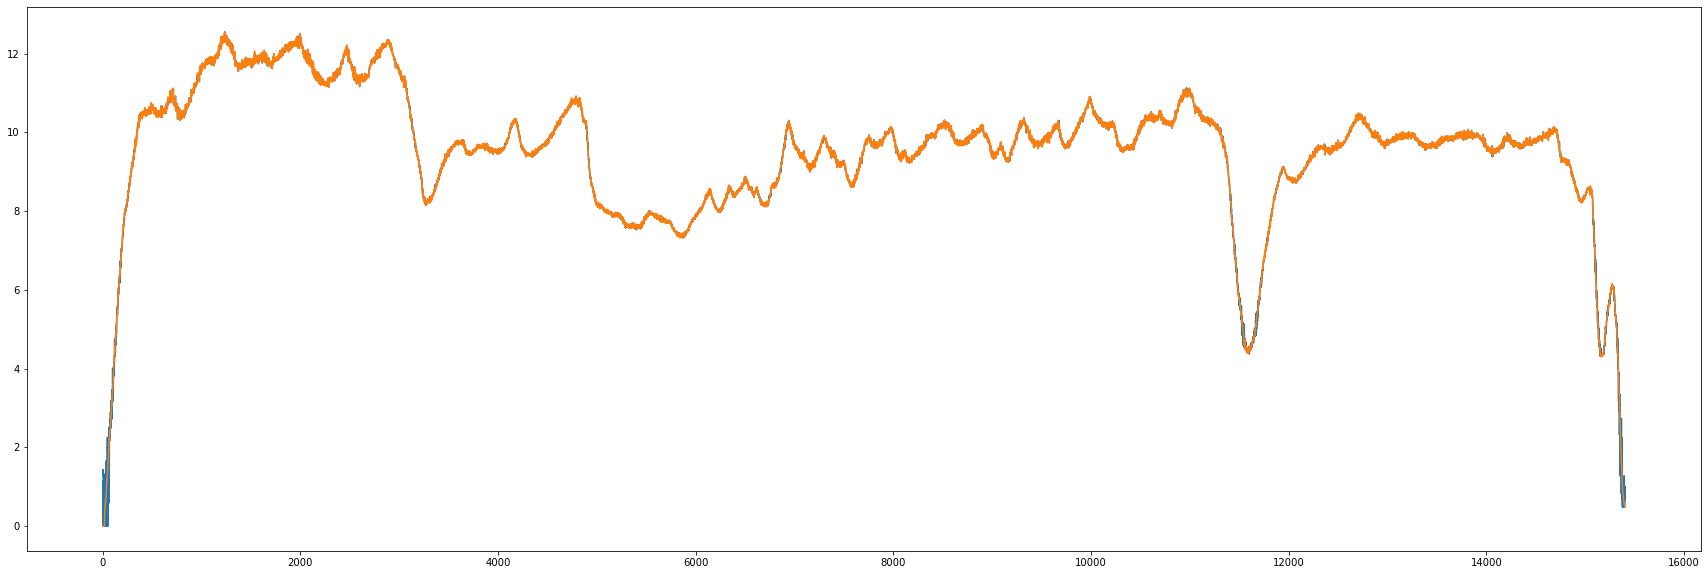

In [28]:
test_df = NvidiaDataset([root_path / "2021-10-11-14-50-59_e2e_rec_vahi"], camera="front_wide", transform=None).frames

x = test_df["position_x"] + np.random.normal(0, 0.5, len(test_df))
y = test_df["position_y"] + np.random.normal(0, 0.5, len(test_df))
yaw = test_df["yaw"] + np.random.normal(0, 0.1, len(test_df))

result_df = pd.DataFrame(data={'x': x, 'y': y, 'yaw': yaw})
result_df['vehicle_speed'] = result_df.apply(lambda x: find_speed_for_position(x['x'], x['y'], x['yaw'])[0], axis=1)
result_df["error"] = np.abs(result_df["vehicle_speed"] - test_df["vehicle_speed"])
print(f"Error mean: {result_df.error.mean()}, max: {result_df.error.max()}")

plt.figure(figsize=(30, 10))
plt.plot(result_df["vehicle_speed"][:15400])
plt.plot(test_df["vehicle_speed"][:15400])

Error mean: 0.8847902437826722, max: 7.890212094071867


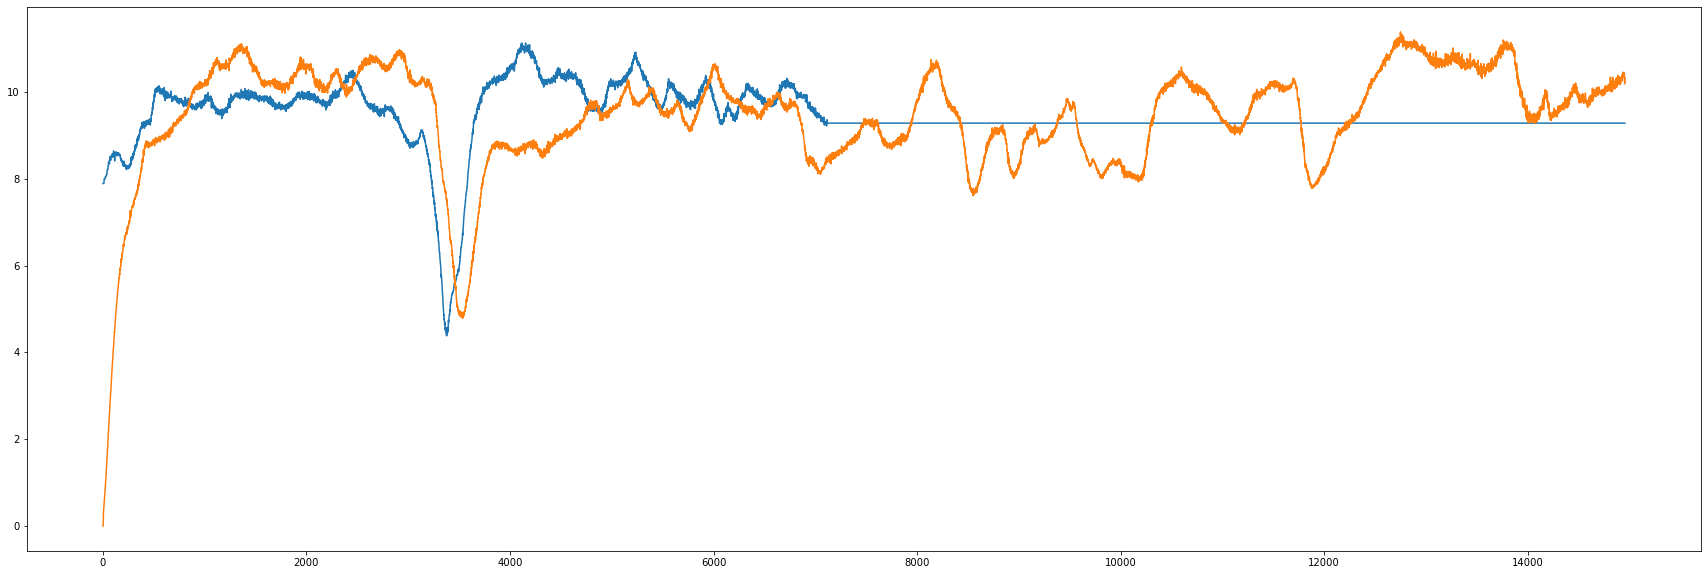

In [13]:
test_df = NvidiaDataset([root_path / "2021-10-11-15-06-10_e2e_rec_vahi_backwards"], camera="front_wide", transform=None).frames

x = test_df["position_x"]# + np.random.normal(0, 0.5, len(test_df))
y = test_df["position_y"]# + np.random.normal(0, 0.5, len(test_df))
yaw = test_df["yaw"]# + np.random.normal(0, 0.1, len(test_df))

result_df = pd.DataFrame(data={'x': x, 'y': y, 'yaw': yaw})
result_df['vehicle_speed'] = result_df.apply(lambda x: find_speed_for_position(x['x'], x['y'], x['yaw'])[0], axis=1)
result_df["error"] = np.abs(result_df["vehicle_speed"] - test_df["vehicle_speed"])
print(f"Error mean: {result_df.error.mean()}, max: {result_df.error.max()}")

plt.figure(figsize=(30, 10))
#result_df = result_df[::-1].reset_index()
#test_df = test_df[::-1].reset_index()
plt.plot(result_df["vehicle_speed"])
plt.plot(test_df["vehicle_speed"])

In [ ]:
test_df[["position_x", "position_y", "yaw"]].iloc[14500:14520]

In [ ]:
result_df.iloc[14540:14560]

In [ ]:
def find_speed_for_position(x, y, yaw): 
    x2 = x + (velocity * np.cos(yaw))
    y2 = y + (velocity * np.sin(yaw))
    
    closest = tree.query([[x, y, x2, y2]])
    #closest = tree.query([[x, y, yaw*100]])
    distance = closest[0][0][0]
    index = closest[1][0][0]
    print(f"distance: {distance:0.5}, index: {index}")
    return positions_df.iloc[index], distance

In [ ]:
#find_speed_for_position(951.006577, -33606.118945, -1.181174)

In [ ]:
#find_speed_for_position(951.578018, -33605.785523, -1.368271)

In [ ]:
#pd.set_option('display.max_colwidth', None)
#positions_df.iloc[[257220]]

In [ ]:
#positions_df.iloc[[329602]]

In [ ]:
paths = [
    root_path / "2021-10-11-14-50-59_e2e_rec_vahi"
]

foobar_df = NvidiaDataset(paths, camera="front_wide", transform=None).frames
plt.figure(figsize=(10, 10))
plt.scatter(foobar_df["position_x"], foobar_df["position_y"],
            s=1,
            c=foobar_df["vehicle_speed"], cmap=plt.cm.coolwarm);

In [ ]:
plt.plot(foobar_df["vehicle_speed"])

In [ ]:
plt.plot(foobar_df["position_x"])

In [ ]:
plt.plot(foobar_df["position_y"])

In [ ]:
paths = [
    root_path / "2021-10-11-15-06-10_e2e_rec_vahi_backwards"
]

foobar_df = NvidiaDataset(paths, camera="front_wide", transform=None).frames
plt.figure(figsize=(10, 10))
plt.scatter(foobar_df["position_x"], foobar_df["position_y"],
            s=1,
            c=foobar_df["vehicle_speed"], cmap=plt.cm.coolwarm);

In [ ]:
plt.plot(foobar_df["position_x"])

In [ ]:
plt.plot(foobar_df["position_y"])

In [ ]:
plt.plot(foobar_df["vehicle_speed"])

In [ ]:
foobar_df.tail(1000)